In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 21 15:37:18 2018

@author: Karandeep Singh
"""
# Seed
RANDOM_SEED=159

# Import libraries
import os
import sys
import glob
import time
import imageio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.misc import imresize 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop, Adam

from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Set display-width of columns to be maximum
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


In [3]:
# Define custom function to plot histograms for training process: Accuracy and Loss histograms
def plot_hist(h, xsize=3, ysize=3):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)

   #  summarize history for accuracy
    plt.subplot(211)
    plt.plot(h['acc'])
    plt.plot(h['val_acc'])
    plt.title('Training vs validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Categorical_Crossentropy Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot
    plt.draw()
    plt.show()

    return

In [4]:
imagedir = "/global/project/queens-mma/shared/Osgoode/DL/VGG/"
labelsfile = "/global/project/queens-mma/shared/Osgoode/DL/VGG/labels.csv"
img_width = 160
img_height = 120

labels = pd.read_csv(labelsfile)
labels = labels.loc[:, ['image', 'category']]
labels['image'] = pd.to_numeric(labels['image'])
labels = labels.dropna()
labels = labels[~labels.category.str.contains(",")]
labels = labels[~labels.category.str.contains("BASOPHIL")] #Remove Basophil rows as we de-scoped that cell-type
labels['category2'] = labels['category']
labels = pd.get_dummies(labels, columns=['category']) #one-hot encode
# We get the below columns names as a result: category_BASOPHIL  Category_EOSINOPHIL  Category_LYMPHOCYTE  
# Category_MONOCYTE  Category_NEUTROPHIL

# Calculate count of different cell-types
eosinophil = labels['category_EOSINOPHIL'].sum()
lymphocyte = labels['category_LYMPHOCYTE'].sum()
neutrophil = labels['category_NEUTROPHIL'].sum()
monocyte = labels['category_MONOCYTE'].sum()

# Print count of cell-types
print("""
Eosinophil {eos}
Lymphocyte {lym}
Neutrophil {neu}
Monocyte   {mono}
""".format(eos=eosinophil, lym=lymphocyte, neu=neutrophil, mono=monocyte))

# Create a new column in labels, in which each entry contains the filename of the image - of use later
# Filename format: "/global/project/queens-mma/shared/Osgoode/DL/VGG/BloodImage_00001.jpg" as an example
labels['filename'] = labels.image.apply(lambda x: imagedir + "BloodImage_" + str(x).zfill(5) + ".jpg")

# Filter for only image files that actually exist
labels = labels[labels['filename'].apply(lambda x: os.path.isfile(x))]


Eosinophil 88
Lymphocyte 33
Neutrophil 207
Monocyte   20



> Class imbalance observed

In [5]:
# Load and resize images
images = []
for x in labels['filename']:
    img = imageio.imread(x)
    img = imresize(img, (img_height,img_width)) #Re-sizing due to computational limitations
    images.append(img)

images = np.array(images) #convert to array
print("No. of images, Height, Width, No. of colors RGB")
print(images.shape)

# Reduce to only 4 categories
y = labels.loc[:,[
    #'Category_BASOPHIL',
    'category_EOSINOPHIL',
                  'category_LYMPHOCYTE', 'category_MONOCYTE',
                  'category_NEUTROPHIL']].values

/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


No. of images, Height, Width, No. of colors RGB
(347, 120, 160, 3)


Train: [ 85  95  98 106 122 140 141 142 144 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276] Test: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  86  87  88  89  90
  91  92  93  94  96  97  99 100 101 102 103 104 105 107 108 

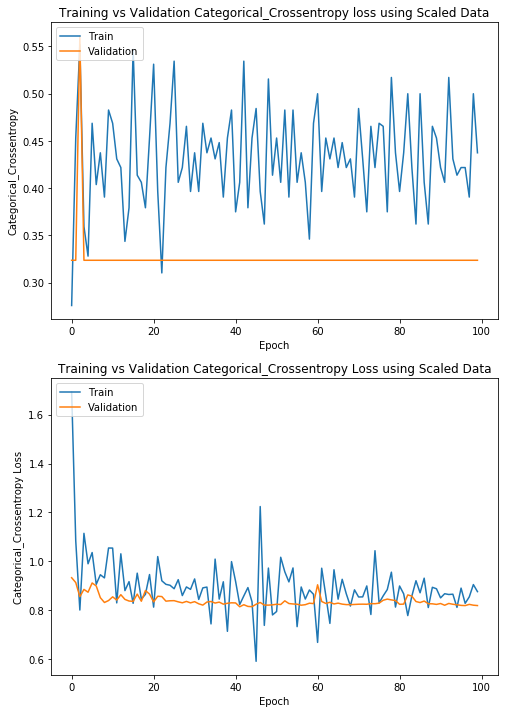

In [15]:
# (Train,Test), (Validate) split => (80%), (20%)
# StratifiedKfold returns stratified folds, i.e while making the folds it maintains the percentage 
# of samples for each class in every fold
X_train_ini, X_val, y_train_ini, y_val = train_test_split(images, labels['category2'], test_size=0.20, stratify=y)

# Now apply 5-fold CV to the (Train,Test) set
skf = StratifiedKFold(n_splits=2, random_state=123)
for train_index, test_index in skf.split(X_train_ini,y_train_ini):  # X is the feature set and y is the target
    print("Train:", train_index, "Test:", test_index) 
    X_train, X_test = X_train_ini[train_index], X_train_ini[test_index] 
    y_train, y_test = y_train_ini[train_index], y_train_ini[test_index]
    # Had to stratify first because StratifiedKfold does not work on one-hot encoded output
    # But, the CNN needs a softmax categorical output with 4 nodes, so we need to one-hot encode
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    
    # Need to augment more data from original 347 images because dataset is very small
    train_gen = ImageDataGenerator(rescale=1. / 255, 
                                   horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest'
                                  )
    test_gen = ImageDataGenerator(rescale=1. / 255,
                                horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')
    train_generator = train_gen.flow(np.array(X_train), 
                                     y_train, 
                                     batch_size = 16) 
    test_generator = test_gen.flow(np.array(X_test), 
                                         y_test,
                                        batch_size = 16)

    # Model Building
    model = Sequential()
    vgg = VGG16(weights = 'imagenet', include_top=False, input_shape = (120,160,3))
    for layer in vgg.layers:
        layer.trainable = False
    print(vgg.summary())

    model = Sequential()
    model.reset_states()
    model.add(vgg)
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))
    model.summary()
    
    opt = RMSprop(lr=0.001, rho = 0.9)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    filepath="refined2_vgg_try_1.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    
    print(len(X_train))
    print(len(X_test))
    
    historyAll = model.fit_generator(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch= len(X_train) // 32,
        validation_steps= len(X_test) // 32,
        epochs=100,
        class_weight = [2.352, 6.272 , 1.000, 15.350], # Type ratio was: 88:33:207:20
        callbacks = [checkpoint],
#         verbose = 0,
        workers = 4,
        use_multiprocessing = True
    )
    break

print(model.evaluate(X_test, y_test))

#Plot Testing and Validation MSE and Loss
plot_hist(historyAll.history, xsize=8, ysize=12)

Train: [129 130 132 134 136 137 138 141 142 145 147 148 150 151 152 153 154 155
 156 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276] Test: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 

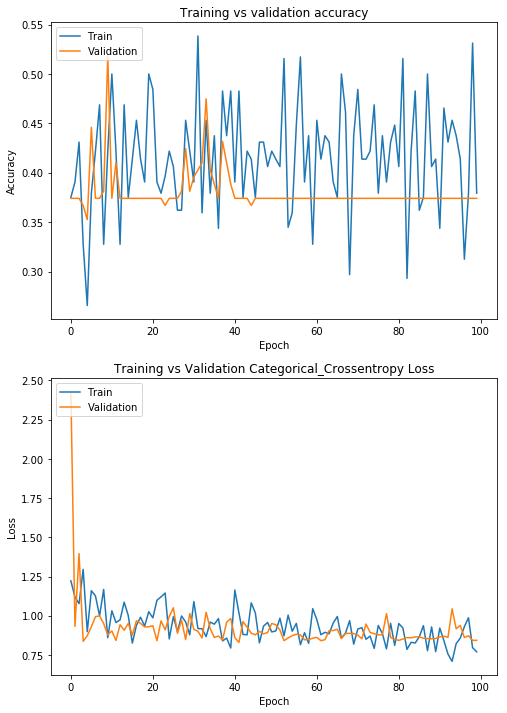

In [20]:
# (Train,Test), (Validate) split => (80%), (20%)
# StratifiedKfold returns stratified folds, i.e while making the folds it maintains the percentage 
# of samples for each class in every fold
X_train_ini, X_val, y_train_ini, y_val = train_test_split(images, labels['category2'], test_size=0.20, stratify=y)

# Now apply 5-fold CV to the (Train,Test) set
skf = StratifiedKFold(n_splits=2, random_state=123)
for train_index, test_index in skf.split(X_train_ini,y_train_ini):  # X is the feature set and y is the target
    print("Train:", train_index, "Test:", test_index) 
    X_train, X_test = X_train_ini[train_index], X_train_ini[test_index] 
    y_train, y_test = y_train_ini[train_index], y_train_ini[test_index]
    # Had to stratify first because StratifiedKfold does not work on one-hot encoded output
    # But, the CNN needs a softmax categorical output with 4 nodes, so we need to one-hot encode
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    
    # Need to augment more data from original 347 images because dataset is very small
    train_gen = ImageDataGenerator(rescale=1. / 255, 
                                   horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest'
                                  )
    test_gen = ImageDataGenerator(rescale=1. / 255,
                                horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')
    train_generator = train_gen.flow(np.array(X_train), 
                                     y_train, 
                                     batch_size = 16) 
    test_generator = test_gen.flow(np.array(X_test), 
                                         y_test,
                                        batch_size = 16)

    # Model Building
    model = Sequential()
    vgg = VGG16(weights = 'imagenet', include_top=False, input_shape = (120,160,3))
    for layer in vgg.layers:
        layer.trainable = False
    print(vgg.summary())

    model = Sequential()
    model.reset_states()
    model.add(vgg)
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))
    model.summary()
    
#     model.load_weights("refined2_vgg_try_1.h5")
    
    opt = RMSprop(lr=0.01, rho = 0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    filepath="refined2_vgg_try_2.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    
    print(len(X_train))
    print(len(X_test))
    
    historyAll = model.fit_generator(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch= len(X_train) // 32,
        validation_steps= len(X_test) // 32,
        epochs=100,
        class_weight = [2.352, 6.272 , 1.000, 15.350], # Type ratio was: 88:33:207:20
        callbacks = [checkpoint],
#         verbose = 0,
        workers = 4,
        use_multiprocessing = True
    )
    break

print(model.evaluate(X_test, y_test))

#Plot Testing and Validation MSE and Loss
plot_hist(historyAll.history, xsize=8, ysize=12)

Train: [129 138 139 141 142 143 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276] Test: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 

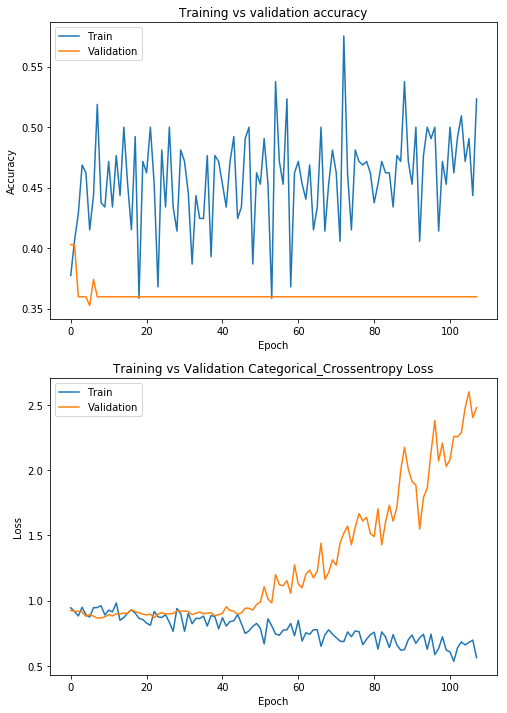

In [27]:
#Increased learning rate from 0.001 to 0.0001 and changed batch_size from 16 to 32, changed class weights. 
# Also introduced eary stopping with patience = 100, and increased epochs from 100 to 300.
# Also initializaing using previous weights.

# (Train,Test), (Validate) split => (80%), (20%)
# StratifiedKfold returns stratified folds, i.e while making the folds it maintains the percentage 
# of samples for each class in every fold
X_train_ini, X_val, y_train_ini, y_val = train_test_split(images, labels['category2'], test_size=0.20, stratify=y)

# Now apply 5-fold CV to the (Train,Test) set
skf = StratifiedKFold(n_splits=2, random_state=123)
for train_index, test_index in skf.split(X_train_ini,y_train_ini):  # X is the feature set and y is the target
    print("Train:", train_index, "Test:", test_index) 
    X_train, X_test = X_train_ini[train_index], X_train_ini[test_index] 
    y_train, y_test = y_train_ini[train_index], y_train_ini[test_index]
    # Had to stratify first because StratifiedKfold does not work on one-hot encoded output
    # But, the CNN needs a softmax categorical output with 4 nodes, so we need to one-hot encode
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    
    # Need to augment more data from original 347 images because dataset is very small
    train_gen = ImageDataGenerator(rescale=1. / 255, 
                                   horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest'
                                  )
    test_gen = ImageDataGenerator(rescale=1. / 255,
                                horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')
    train_generator = train_gen.flow(np.array(X_train), 
                                     y_train, 
                                     batch_size = 32) 
    test_generator = test_gen.flow(np.array(X_test), 
                                         y_test,
                                        batch_size = 32)

    # Model Building
    model = Sequential()
    vgg = VGG16(weights = 'imagenet', include_top=False, input_shape = (120,160,3))
    for layer in vgg.layers:
        layer.trainable = False
    print(vgg.summary())

    model = Sequential()
    model.reset_states()
    model.add(vgg)
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))
    model.summary()
    
    model.load_weights("refined2_vgg_try_3.h5")
    
    opt = RMSprop(lr=0.0001, rho = 0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    filepath="refined2_vgg_try_4.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=100) #wait for 100 epochs before ES
    print(len(X_train))
    print(len(X_test))
    
    historyAll = model.fit_generator(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch= len(X_train) // 32,
        validation_steps= len(X_test) // 32,
        epochs=300,
        class_weight = [2.352, 8.272 , 1.000, 15.350], # Type ratio was: 88:33:207:20
        callbacks = [checkpoint,es],
#         verbose = 0,
        workers = 4,
        use_multiprocessing = True
    )
    break

print(model.evaluate(X_test, y_test))

#Plot Testing and Validation MSE and Loss
plot_hist(historyAll.history, xsize=8, ysize=12)

Train: [125 126 130 138 139 140 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 165 166 167 168 169 170 171 173
 174 175 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276] Test: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 

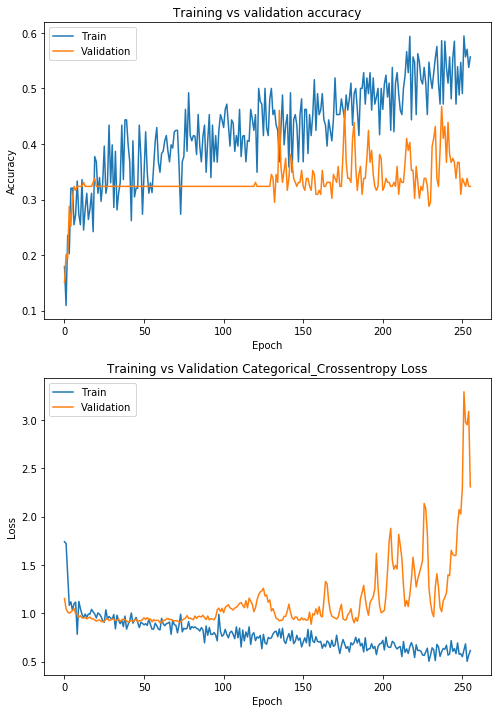

In [35]:
# Overfitting suspected. Changing the dropout values from 0.3 to 0.4. Used Adam instead of RMSProp. 1000 epochs.

# (Train,Test), (Validate) split => (80%), (20%)
# StratifiedKfold returns stratified folds, i.e while making the folds it maintains the percentage 
# of samples for each class in every fold
X_train_ini, X_val, y_train_ini, y_val = train_test_split(images, labels['category2'], test_size=0.20, stratify=y)

# Now apply 5-fold CV to the (Train,Test) set
skf = StratifiedKFold(n_splits=2, random_state=123)
for train_index, test_index in skf.split(X_train_ini,y_train_ini):  # X is the feature set and y is the target
    print("Train:", train_index, "Test:", test_index) 
    X_train, X_test = X_train_ini[train_index], X_train_ini[test_index] 
    y_train, y_test = y_train_ini[train_index], y_train_ini[test_index]
    # Had to stratify first because StratifiedKfold does not work on one-hot encoded output
    # But, the CNN needs a softmax categorical output with 4 nodes, so we need to one-hot encode
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    
    # Need to augment more data from original 347 images because dataset is very small
    train_gen = ImageDataGenerator(rescale=1. / 255, 
                                   horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest'
                                  )
    test_gen = ImageDataGenerator(rescale=1. / 255,
                                horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')
    train_generator = train_gen.flow(np.array(X_train), 
                                     y_train, 
                                     batch_size = 32) 
    test_generator = test_gen.flow(np.array(X_test), 
                                         y_test,
                                        batch_size = 32)

    # Model Building
    model = Sequential()
    vgg = VGG16(weights = 'imagenet', include_top=False, input_shape = (120,160,3))
    for layer in vgg.layers:
        layer.trainable = False
    print(vgg.summary())

    model = Sequential()
    model.reset_states()
    model.add(vgg)
#     model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
#     model.add(BatchNormalization())
#     model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
#     model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))
    model.summary()
    
#     model.load_weights("refined2_vgg_try_3.h5")
    
    opt = Adam(lr=0.0001) #, rho = 0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    filepath="refined2_vgg_try_4.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=100) #wait for 100 epochs before ES
    print(len(X_train))
    print(len(X_test))
    
    historyAll = model.fit_generator(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch= len(X_train) // 32,
        validation_steps= len(X_test) // 32,
        epochs=1000,
        class_weight = [2.352, 8.272 , 1.000, 15.350], # Type ratio was: 88:33:207:20
        callbacks = [checkpoint,es],
#         verbose = 0,
        workers = 4,
        use_multiprocessing = True
    )
    break

print(model.evaluate(X_test, y_test))

#Plot Testing and Validation MSE and Loss
plot_hist(historyAll.history, xsize=8, ysize=12)

Train: [130 134 136 137 138 140 142 143 144 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276] Test: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 

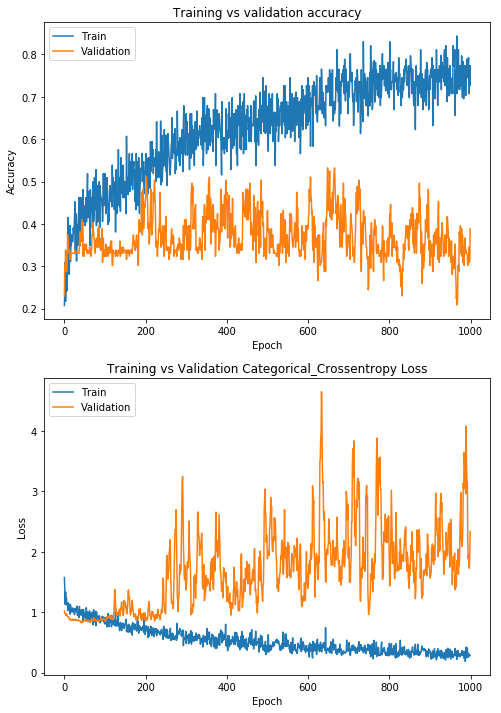

In [36]:
# Training loss is still decr. - Minima has not yet occured. Remove ES and run for 1000 epochs.

# (Train,Test), (Validate) split => (80%), (20%)
# StratifiedKfold returns stratified folds, i.e while making the folds it maintains the percentage 
# of samples for each class in every fold
X_train_ini, X_val, y_train_ini, y_val = train_test_split(images, labels['category2'], test_size=0.20, stratify=y)

# Now apply 5-fold CV to the (Train,Test) set
skf = StratifiedKFold(n_splits=2, random_state=123)
for train_index, test_index in skf.split(X_train_ini,y_train_ini):  # X is the feature set and y is the target
    print("Train:", train_index, "Test:", test_index) 
    X_train, X_test = X_train_ini[train_index], X_train_ini[test_index] 
    y_train, y_test = y_train_ini[train_index], y_train_ini[test_index]
    # Had to stratify first because StratifiedKfold does not work on one-hot encoded output
    # But, the CNN needs a softmax categorical output with 4 nodes, so we need to one-hot encode
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    
    # Need to augment more data from original 347 images because dataset is very small
    train_gen = ImageDataGenerator(rescale=1. / 255, 
                                   horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest'
                                  )
    test_gen = ImageDataGenerator(rescale=1. / 255,
                                horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')
    train_generator = train_gen.flow(np.array(X_train), 
                                     y_train, 
                                     batch_size = 32) 
    test_generator = test_gen.flow(np.array(X_test), 
                                         y_test,
                                        batch_size = 32)

    # Model Building
    model = Sequential()
    vgg = VGG16(weights = 'imagenet', include_top=False, input_shape = (120,160,3))
    for layer in vgg.layers:
        layer.trainable = False
    print(vgg.summary())

    model = Sequential()
    model.reset_states()
    model.add(vgg)
#     model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
#     model.add(BatchNormalization())
#     model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
#     model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))
    model.summary()
    
#     model.load_weights("refined2_vgg_try_3.h5")
    
    opt = Adam(lr=0.0001) #, rho = 0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    filepath="refined2_vgg_try_4.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=100) #wait for 100 epochs before ES
    print(len(X_train))
    print(len(X_test))
    
    historyAll = model.fit_generator(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch= len(X_train) // 32,
        validation_steps= len(X_test) // 32,
        epochs=1000,
        class_weight = [2.352, 8.272 , 1.000, 15.350], # Type ratio was: 88:33:207:20
        callbacks = [checkpoint],
#         verbose = 0,
        workers = 4,
        use_multiprocessing = True
    )
    break

print(model.evaluate(X_test, y_test))

#Plot Testing and Validation MSE and Loss
plot_hist(historyAll.history, xsize=8, ysize=12)

Train: [114 126 127 128 131 132 139 142 144 146 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276] Test: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 

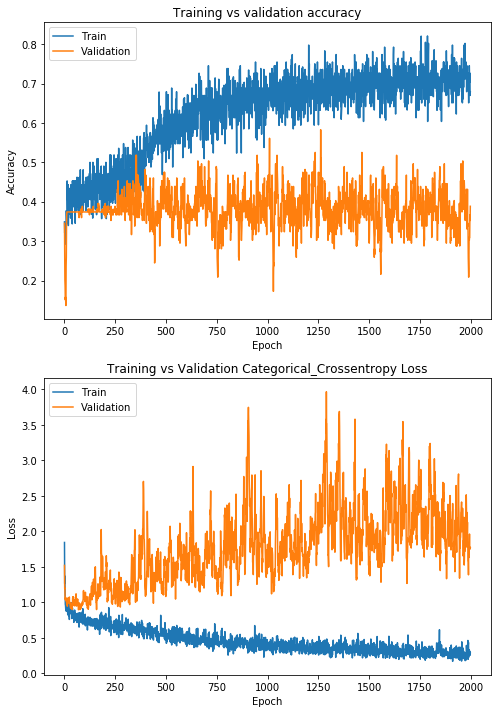

In [7]:
#Changing the image generator : added zoom_range = 0.3, epochs = 2000, initializae with previous weights file

# (Train,Test), (Validate) split => (80%), (20%)
# StratifiedKfold returns stratified folds, i.e while making the folds it maintains the percentage 
# of samples for each class in every fold
X_train_ini, X_val, y_train_ini, y_val = train_test_split(images, labels['category2'], test_size=0.20, stratify=y)

# Now apply 5-fold CV to the (Train,Test) set
skf = StratifiedKFold(n_splits=2, random_state=123)
for train_index, test_index in skf.split(X_train_ini,y_train_ini):  # X is the feature set and y is the target
    print("Train:", train_index, "Test:", test_index) 
    X_train, X_test = X_train_ini[train_index], X_train_ini[test_index] 
    y_train, y_test = y_train_ini[train_index], y_train_ini[test_index]
    # Had to stratify first because StratifiedKfold does not work on one-hot encoded output
    # But, the CNN needs a softmax categorical output with 4 nodes, so we need to one-hot encode
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    
    # Need to augment more data from original 347 images because dataset is very small
    train_gen = ImageDataGenerator(rescale=1. / 255, 
                                   horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.3,
                                   fill_mode='nearest'
                                  )
    test_gen = ImageDataGenerator(rescale=1. / 255,
                                horizontal_flip=True, 
                                   rotation_range=20,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.3,
                                   fill_mode='nearest')
    train_generator = train_gen.flow(np.array(X_train), 
                                     y_train, 
                                     batch_size = 32) 
    test_generator = test_gen.flow(np.array(X_test), 
                                         y_test,
                                        batch_size = 32)

    # Model Building
    model = Sequential()
    vgg = VGG16(weights = 'imagenet', include_top=False, input_shape = (120,160,3))
    for layer in vgg.layers:
        layer.trainable = False
    print(vgg.summary())

    model = Sequential()
    model.reset_states()
    model.add(vgg)
#     model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
#     model.add(BatchNormalization())
#     model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
#     model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))
    model.summary()
    
    model.load_weights("refined2_vgg_try_4.h5")
    
    opt = Adam(lr=0.0001) #, rho = 0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    filepath="refined2_vgg_try_5.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=100) #wait for 100 epochs before ES
    print(len(X_train))
    print(len(X_test))
    
    historyAll = model.fit_generator(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch= len(X_train) // 32,
        validation_steps= len(X_test) // 32,
        epochs=2000,
        class_weight = [2.352, 8.272 , 1.000, 15.350], # Type ratio was: 88:33:207:20
        callbacks = [checkpoint],
#         verbose = 0,
        workers = 4,
        use_multiprocessing = True
    )
    break

print(model.evaluate(X_test, y_test))

#Plot Testing and Validation MSE and Loss
plot_hist(historyAll.history, xsize=8, ysize=12)

Steps taken:
1. Iteration 1: Use lr = 0.00001 and decay = 0.0001, 300 epochs
2. Iteration 2: Use lr = 0.00001 and decay = 0.1, initializing with previously saved weights from Iteration 1, Early Stopping
3. Iteration 3: ImageGenerator
Improvements:
    1. No. of splits in k-fold CV could be increased
    2. Varying the class weights
    3. Re-training with saved weights
    4. Hyperparameter tuning of the optimizer (optimizer type, decay, other parameters)
    
Observations:
1. Chaging the class_weights did have an impact on the accuracy

In [2]:
References:
https://keras.io/applications/#vgg16